# <span style='color:#FF8383'>Assignment 15</span>
## <span style='color:#6A9C89'> LGBM (Light Gradient Boost Machine) and XGBM (Extra Gradient Boost Machine) </span>

## <span style='color:#6A9C89'>Objective</span>
    The objective of this assignment is to compare the performance of Light GBM and XG Boost algorithms using the Titanic dataset.

## <span style='color:#6A9C89'>Assignment Walk-Through</span>
    1. Exploratory Data Analysis (EDA)
    2. Data Pre-Processing
    3. Building Predictive Models
    4. Comparative Analysis

### <span style='color:#6A9C89'>Data Preparation</span>

In [139]:
## importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## notebook settings
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
print('Imported')

Imported


In [140]:
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

In [141]:
print('Shape of Training Dataset')
print(train_df.shape)
print('Shape of Testing Dataset')
print(test_df.shape)

Shape of Training Dataset
(891, 12)
Shape of Testing Dataset
(418, 11)


In [142]:
## columns
train_columns = train_df.columns
test_columns = test_df.columns

In [143]:
## we can see that, testing csv file has one less column than training file
## checking the mising column, list comprehension for missing columns
[x for x in train_columns if not x in test_columns]         ## target column

['Survived']

In [144]:
## information about the data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [145]:
## description
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [146]:
## checking for null values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [147]:
## removing null values
## Age      ==>  int
## Cabin    ==>  object
## Embarked ==>  object
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)                    ## replacing with mean of age
train_df['Cabin'].fillna(train_df['Cabin'].mode()[0], inplace=True)             ## replacing with most repeating value (Cabin)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)       ## replacing with most repeating value (Embarked)
print('Filled Null Values')

Filled Null Values


In [148]:
## checking for null values
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Now, we dont have any null values.

### <span style='color:#6A9C89'>1. Exploratory Data Analysis</span>

In [149]:
## let's separate the taining columns into numerical and categorical columns
num_cols = [col for col in train_columns if train_df[col].dtype != 'object']        ## numerical columns
cat_cols = [col for col in train_columns if train_df[col].dtype == 'object']        ## categorical columns

In [150]:
print(f'Number of Numerical Columns {len(num_cols)}')
print(num_cols)
print(f'Number of Categorical Columns {len(cat_cols)}')
print(cat_cols)

Number of Numerical Columns 7
['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Number of Categorical Columns 5
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


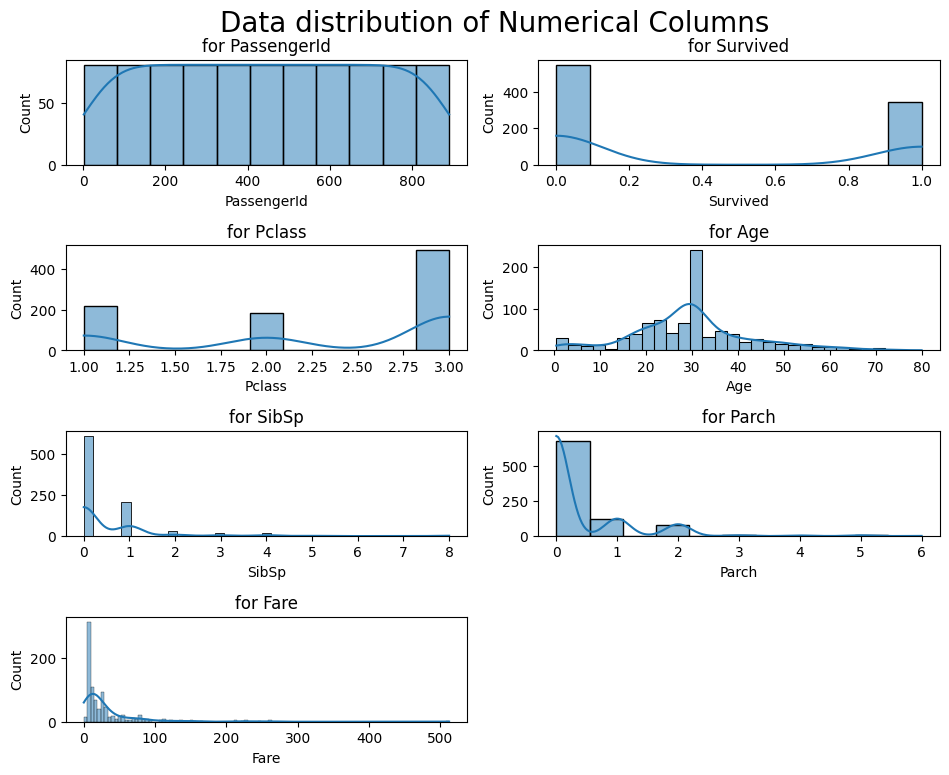

In [151]:
## Histograms for Numerical Columns
## Seeing the data distribution for the numerical columns
total_cols = len(num_cols)
plt.figure(figsize=(10,15))
plt.suptitle('Data distribution of Numerical Columns', fontsize=20)
for idx, num in enumerate(num_cols, 1):
    plt.subplot(8, 2, idx)
    sns.histplot(data=train_df, x=num, kde=True)
    plt.title(f'for {num}')
plt.tight_layout(rect=[0,0,0.96,1])
plt.show()

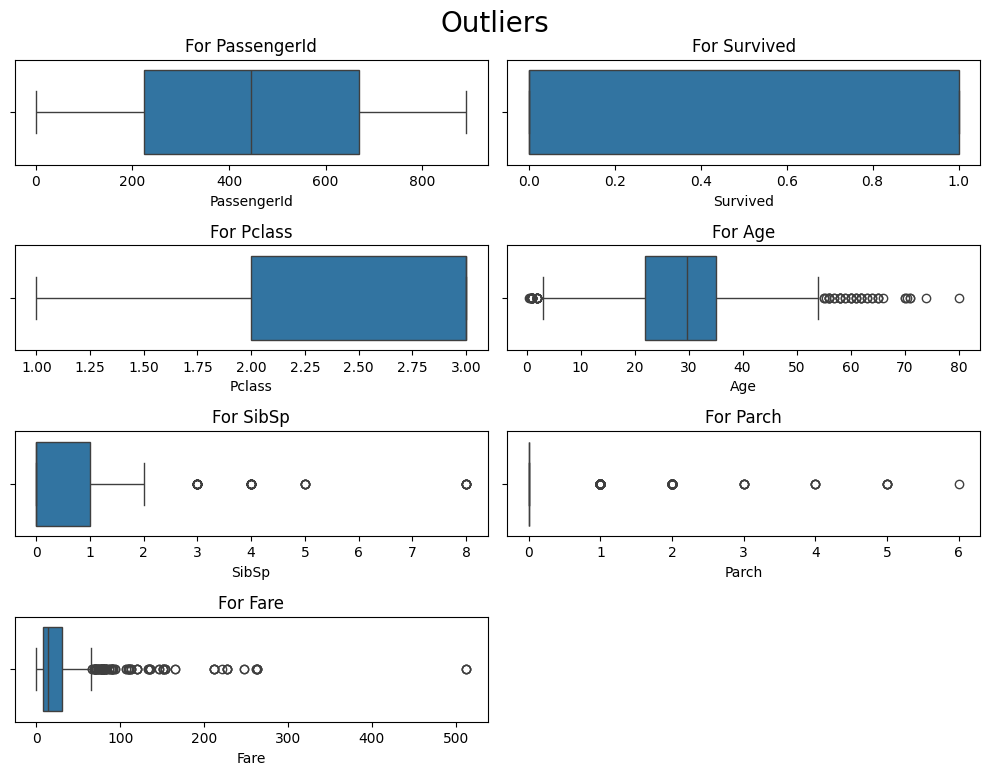

In [152]:
## checking for the outliers
plt.figure(figsize=(10,15))
plt.suptitle('Outliers', fontsize=20)
for idx, num in enumerate(num_cols, 1):
    plt.subplot(8, 2, idx)
    sns.boxplot(data=train_df, x=num)
    plt.title(f'For {num}')
plt.tight_layout()
plt.show()

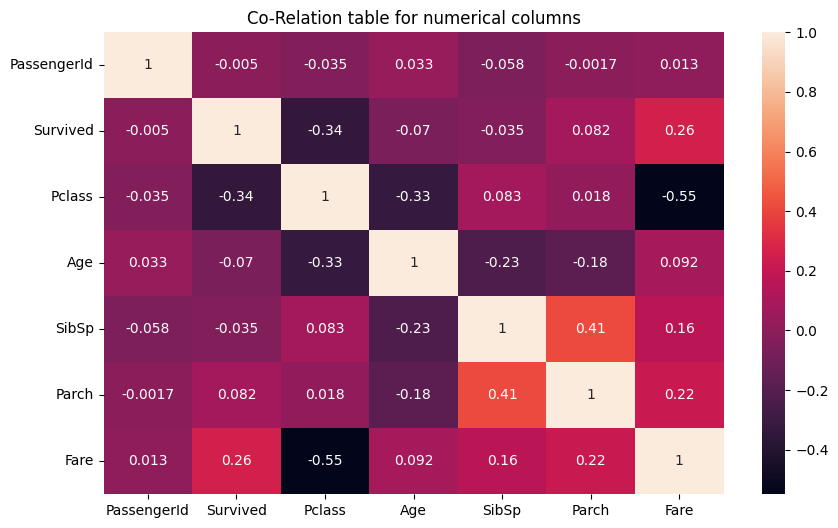

In [153]:
## heatmap
plt.figure(figsize=(10,6))
plt.title('Co-Relation table for numerical columns')
sns.heatmap(train_df[num_cols].corr(), annot=True)
plt.show()

In [154]:
def correlation(dataset, threshold):
    col_corr = set()  # Set to store column names with high correlation
    corr_matrix = dataset.corr()  # Calculate correlation matrix
    
    for i in range(len(corr_matrix.columns)):  # Loop through columns
        for j in range(i):  # Loop through rows before the diagonal
            if abs(corr_matrix.iloc[i, j]) >= threshold:  # Access with iloc
                col_name = corr_matrix.columns[i]  # Get the column name
                col_corr.add(col_name)  # Add the column name to the set
    return col_corr

In [155]:
## let's check the multi-colinearity for the above numerical columns
threshold_values = [0.60,0.50,0.40,0.30]
print('*'*50)
for i in threshold_values:
    print(f'For threshold value = {i}')
    print(f'There are {len(correlation(train_df[num_cols], i))}')
    print(f'With columns : \n {correlation(train_df[num_cols], i)}')
    print('*'*50)

**************************************************
For threshold value = 0.6
There are 0
With columns : 
 set()
**************************************************
For threshold value = 0.5
There are 1
With columns : 
 {'Fare'}
**************************************************
For threshold value = 0.4
There are 2
With columns : 
 {'Parch', 'Fare'}
**************************************************
For threshold value = 0.3
There are 4
With columns : 
 {'Age', 'Parch', 'Pclass', 'Fare'}
**************************************************


##### So the mainly related columns are
    Age, SibSp, Parch, Fare and Pclas

In [156]:
## comparing survival rate across Age, SibSp, Parch, Fare and Pclass
surv_rate = pd.pivot_table(data=train_df[num_cols], values = ['Age','SibSp', 'Parch', 'Fare', 'Pclass'], index='Survived' )
surv_rate

,Age,Fare,Parch,Pclass,SibSp
Survived,,,,,
0,30.415100,22.117887,0.329690,2.531876,0.553734
1,28.549778,48.395408,0.464912,1.950292,0.473684


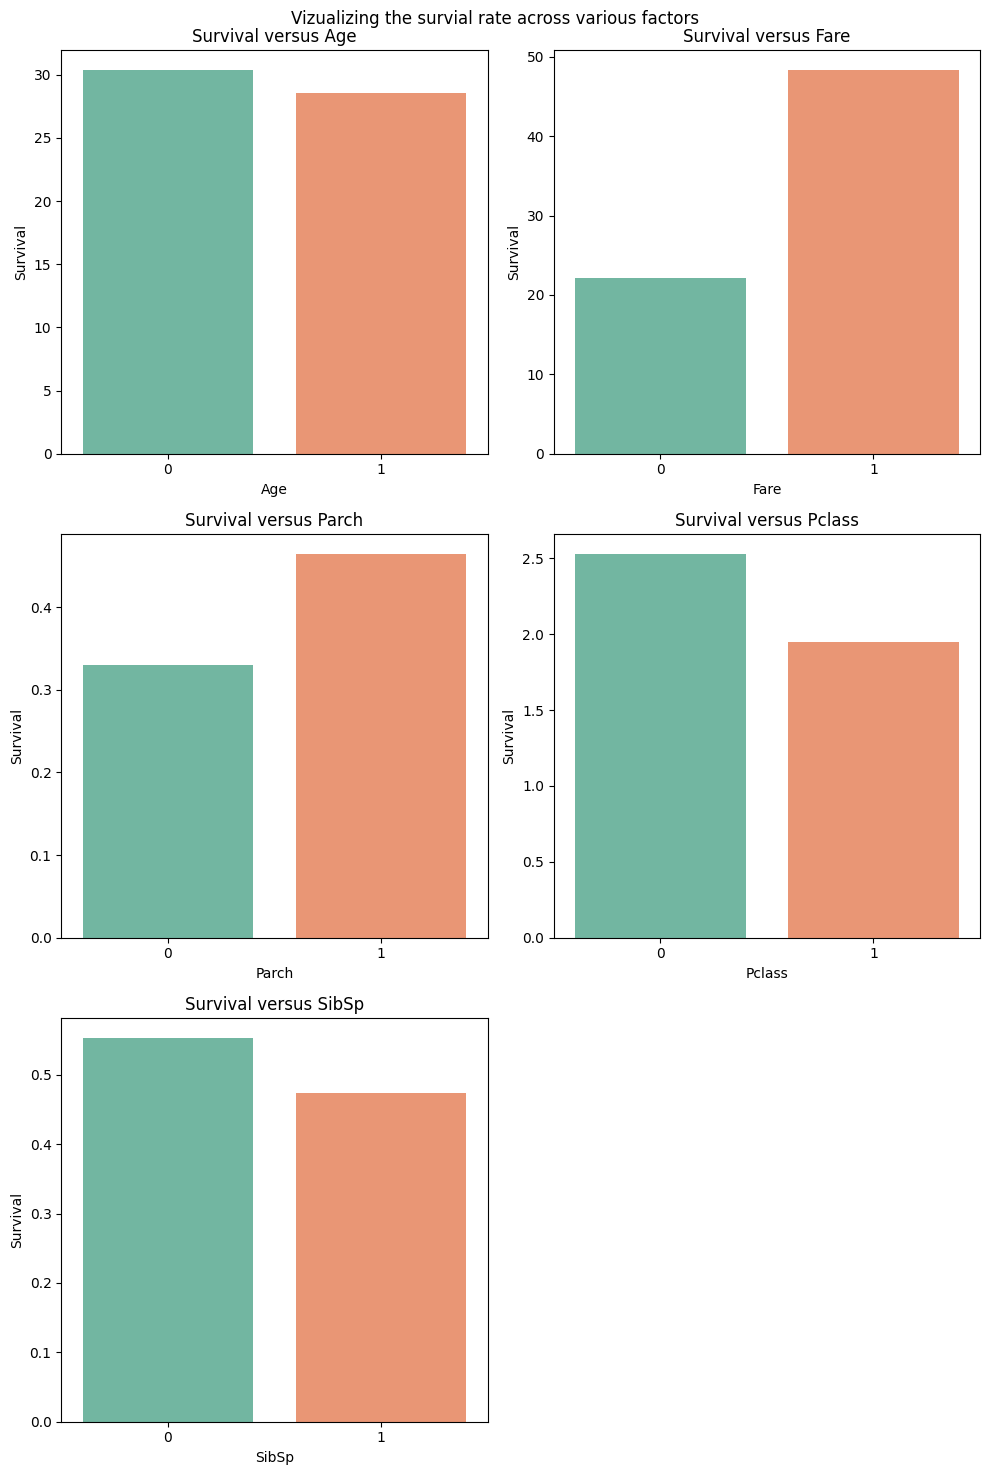

In [157]:
## Let's vizualize the survial rate across various values
plt.figure(figsize=(10,15))
plt.suptitle('Vizualizing the survial rate across various factors')
for idx, col in enumerate(surv_rate.columns, 1):
    plt.subplot(3, 2, idx)
    plt.title(f'Survival versus {col}')
    sns.barplot(data=surv_rate, x=surv_rate.index, y=surv_rate[col], palette='Set2')
    plt.xlabel(f'{col}')
    plt.ylabel('Survival')
plt.tight_layout()
plt.show()

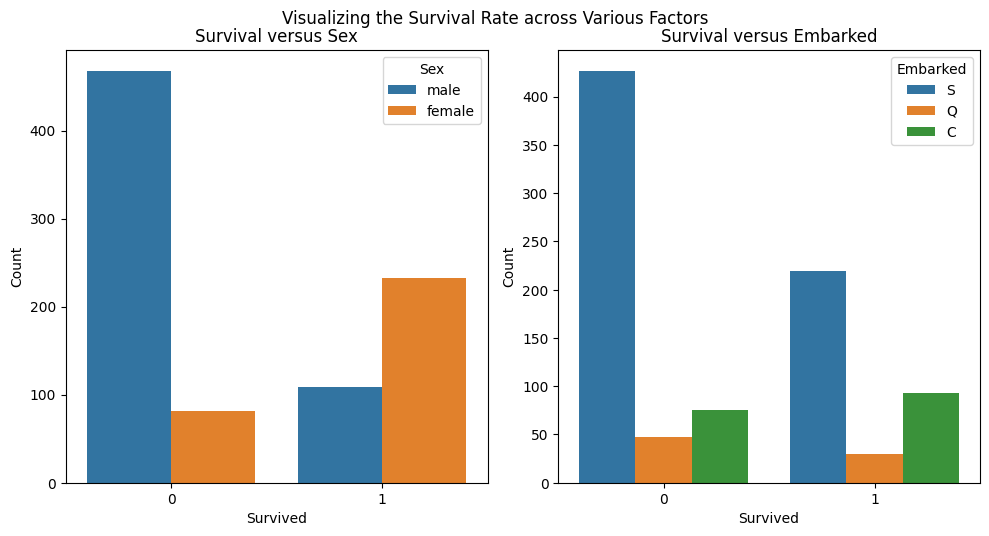

In [158]:
## Let's vizualize the survial rate across various values

# Specify the columns to plot
new_cols = ['Sex', 'Embarked']  # 'Ticket' and 'Cabin' are not directly plottable due to unique values

plt.figure(figsize=(10, 15))
plt.suptitle('Visualizing the Survival Rate across Various Factors')

for idx, col in enumerate(new_cols, 1):
    plt.subplot(3, 2, idx)
    plt.title(f'Survival versus {col}')
    
    # Plot the count of each category for Survived and Not Survived
    sns.countplot(data=train_df, x='Survived', hue=col)
    
    plt.xlabel('Survived')
    plt.ylabel('Count')
    
plt.tight_layout()
plt.show()


### <span style='color:#6A9C89'>2. Feature Engineering</span>

In [159]:
## let's drop un-necessary columns
train_df.drop(columns=['PassengerId'], inplace=True)

In [160]:
## let's check each of the columns for distinct categories
train_df.Cabin.value_counts()

B96 B98        691
G6               4
C23 C25 C27      4
C22 C26          3
F33              3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 147, dtype: int64

In [161]:
## checks if the cabin is null and if not, it will split the string and it will put number of cabin assigned to the person
train_df['cabin_multiple'] = train_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' '))) 
train_df['cabin_multiple'].value_counts()

2    703
1    180
3      6
4      2
Name: cabin_multiple, dtype: int64

In [162]:
## survival rate based on multiple cabins
pd.pivot_table(data=train_df, columns = ['cabin_multiple'], index='Survived', values='Ticket', aggfunc='count')

cabin_multiple,1,2,3,4
Survived,,,,
0,58.0,488.0,3.0,NaN
1,122.0,215.0,3.0,2.0


In [163]:
## function for removing the outliers
def remove_outliers(df, columns, threshold=1.5):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        ## Filter rows within the bounds using element-wise logical AND
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [164]:
## defining a variabe to take all the columns with maximum number of outliers
outlier_cols = ['Fare', 'Age']

In [165]:
train_df = remove_outliers(train_df, outlier_cols, threshold=1.5)

### <span style='color:#6A9C89'>3. Data Pre-Processing</span>

In [166]:
train_df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_multiple
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,B96 B98,S,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,B96 B98,S,2


In [167]:
## drop un-wanted columns
train_df.drop(columns=['Name','Ticket','Cabin'], inplace=True)

In [168]:
## new training dataset
train_df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_multiple
0,0,3,male,22.0,1,0,7.250,S,2
2,1,3,female,26.0,0,0,7.925,S,2


In [169]:
## check the shape of the dataset
train_df.shape

(708, 9)

In [170]:
## applying label encoding to the independent variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
columns_to_encode = ['Sex', 'Embarked']
for col in columns_to_encode:
    train_df[col] = le.fit_transform(train_df[col])

In [171]:
train_df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_multiple
0,0,3,1,22.0,1,0,7.250,2,2
2,1,3,0,26.0,0,0,7.925,2,2


### <span style='color:#6A9C89'>4. Building Predictive Models</span>

In [172]:
## separating the dataset into independent and dependent variables
x = train_df.drop(columns='Survived', axis=1)
y = train_df.Survived

In [173]:
## splitting the dataset into training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

In [174]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((531, 8), (177, 8), (531,), (177,))

In [175]:
## build predictive models using LGBM and XGBoost
from xgboost import XGBClassifier                 ## Extra Gradient Boost Classifier
from lightgbm import LGBMClassifier               ## Light Gradient Boost Classifier

In [176]:
models = [
    ('Extra Gradient Boost Classifier',
    XGBClassifier(),
     {
         'n_estimators': [100, 300, 500, 700, 900],  # Number of boosting rounds
         'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1.0],  # Boosting learning rate
         'max_depth': [3, 5, 7, 9, 11],  # Maximum depth of trees
         'gamma': [0, 0.1, 0.2, 0.3],
         'objective': ['binary:logistic', 'multi:softmax', 'multi:softprob'],  # Learning objective
         'booster': ['gbtree', 'gblinear', 'dart'],  # Booster type,
         'eval_metric': ['logloss', 'error', 'auc'],  
     }
    ),
    ('Light Gradient Boost Classifier',
    LGBMClassifier(),
     {
         'n_estimators': [100, 300, 500, 700, 900],  # Number of boosting rounds
         'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1.0],  # Boosting learning rate
         'max_depth': [3, 5, 7, 9, 11],  # Maximum depth of trees
         'num_leaves': [31, 50, 70, 100],  # Number of leaves in a full tree
         'boosting_type': ['gbdt', 'dart', 'goss'],  # Boosting type
         'objective': ['binary', 'multiclass', 'multiclassova'],  # Learning objective
         'metric': ['binary_error', 'multi_logloss', 'auc'],  # Evaluation metrics
         'feature_fraction': [0.6, 0.8, 1.0],  # Fraction of features used for training
         'bagging_fraction': [0.6, 0.8, 1.0],  # Fraction of data used for training
         'bagging_freq': [0, 5, 10],  # Bagging frequency
         'min_data_in_leaf': [20, 50, 100],  # Minimum number of data points in a leaf
     }
    )
]

In [177]:
## hyper-parameter tunning for Extra Gradient Boosting and Light Gradient Boosting 
from sklearn.model_selection import RandomizedSearchCV
model_param = {}
for name, model, param in models:
    randomCV = RandomizedSearchCV(
        estimator = model, 
        param_distributions = param, 
        n_iter = 100, 
        verbose = 2, 
        cv = 5, 
        n_jobs = -1
    )
    randomCV.fit(x_train, y_train)
    model_param[name] = randomCV.best_params_

for model in model_param:
    print(f'-------------------------- Best Params for {model} --------------------------')
    print(model_param[model])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is s

In [178]:
## let's make a function for evaluating model performance
def evaluate_models(true, predicted):
    accuracy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted, average='micro')
    f1 = f1_score(true, predicted, average='micro')
    return accuracy, precision, f1

In [179]:
models_with_parameters = {
    'Extra Gradient Boosting Classifier' : XGBClassifier(objective='binary:logistic', n_estimators=300, max_depth=11, learning_rate=0.01, gamma=0.2, eval_metric='error', booster='gbtree'),
    'Light Gradient Boosting Classifier' : LGBMClassifier(objective='binary', num_leaves=31, n_estimators=900, min_data_in_leaf=20, metric='binary_error', max_depth=5, learning_rate=0.01, feature_fraction=1.0, boosting_type='goss', bagging_freq=5, bagging_fraction=1.0)
}

In [180]:
## Initialize lists for storing results
from sklearn.metrics import accuracy_score, precision_score, f1_score
new_model_list = []
new_f1_values = []
new_results = []

## Evaluate each model
for model_name, model in models_with_parameters.items():
    # Fit the model
    model.fit(x_train, y_train)

    # Make predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Evaluate the model
    model_train_accuracy, model_train_precision, model_train_f1 = evaluate_models(y_train, y_train_pred)
    model_test_accuracy, model_test_precision, model_test_f1 = evaluate_models(y_test, y_test_pred)

    # Calculate F1 Score difference
    new_f1_difference = abs(model_train_f1 - model_test_f1) * 100

    # Print results
    print(model_name)
    print('=' * 50)
    print('Model Performance for Training Set')
    print(f'-- Accuracy Score: {np.round(model_train_accuracy, 2)}')
    print(f'-- Precision Score: {np.round(model_train_precision, 2)}')
    print(f'-- F1 Score: {np.round(model_train_f1, 2)}')
    print('-' * 50)
    print('Model Performance for Testing Set')
    print(f'-- Accuracy Score: {np.round(model_test_accuracy, 2)}')
    print(f'-- Precision Score: {np.round(model_test_precision, 2)}')
    print(f'-- F1 Score: {np.round(model_test_f1, 2)}')
    print('=' * 50)

    # Store results
    new_results.append({
        "Model": model_name,
        "Train Accuracy": np.round(model_train_accuracy, 2),
        "Train Precision": np.round(model_train_precision, 2),
        "Train F1": np.round(model_train_f1, 2),
        "Test Accuracy": np.round(model_test_accuracy, 2),
        "Test Precision": np.round(model_test_precision, 2),
        "Test F1": np.round(model_test_f1, 2),
        "F1 Difference": np.round(new_f1_difference, 2)
    })


Extra Gradient Boosting Classifier
Model Performance for Training Set
-- Accuracy Score: 0.91
-- Precision Score: 0.91
-- F1 Score: 0.91
--------------------------------------------------
Model Performance for Testing Set
-- Accuracy Score: 0.81
-- Precision Score: 0.81
-- F1 Score: 0.81
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_da

In [182]:
results_df = pd.DataFrame(new_results)

In [183]:
results_df

,Model,Train Accuracy,Train Precision,Train F1,Test Accuracy,Test Precision,Test F1,F1 Difference
0,Extra Gradient Boosting Classifier,0.91,0.91,0.91,0.81,0.81,0.81,10.17
1,Light Gradient Boosting Classifier,0.87,0.87,0.87,0.85,0.85,0.85,2.26


### <span style='color:#6A9C89'>5. Comparative Analysis</span>

In [184]:
## Transforms the DataFrame into a format suitable for grouped bar plots by turning metrics into a single column
viz_res_df = results_df.melt(id_vars="Model", var_name="Metric", value_name="Value") 

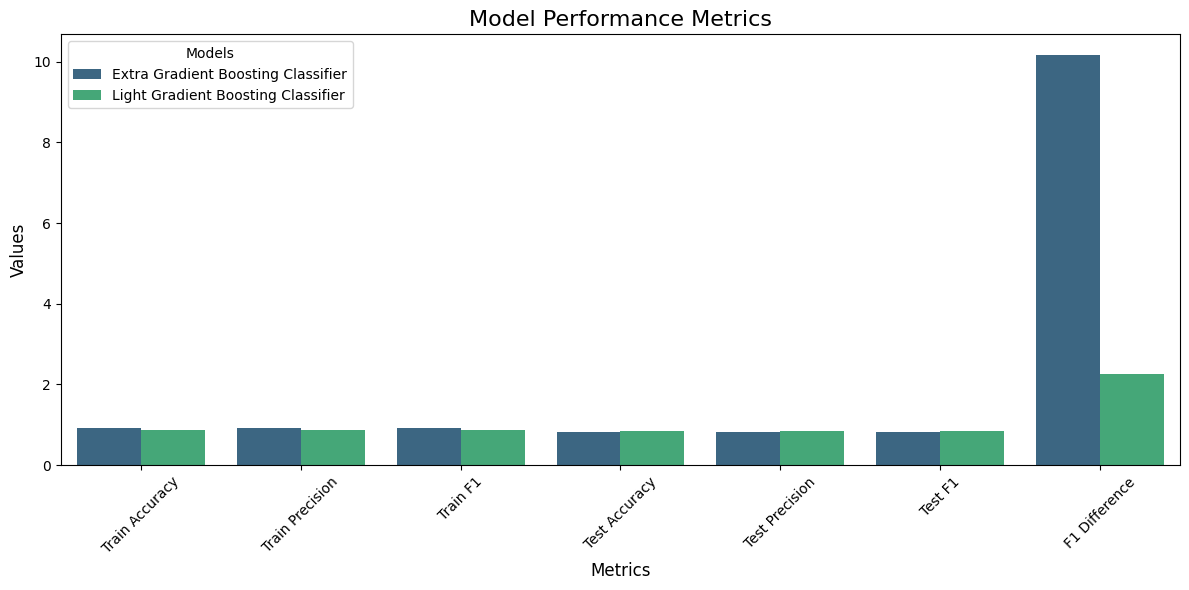

In [185]:
plt.figure(figsize=(12, 6))
sns.barplot(data=viz_res_df, x="Metric", y="Value", hue="Model", palette="viridis")
plt.title("Model Performance Metrics", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Models", fontsize=10)
plt.tight_layout()
plt.show()

### <span style='color:#6A9C89'>6. Conclusion</span>
##### The comparison between the two models reveals that the Extra Gradient Boosting Classifier (XGBoost) slightly outperforms the Light Gradient Boosting Classifier (LGBM) in training performance, achieving higher accuracy, precision, and F1 scores (0.92 vs. 0.89). However, on the testing set, both models show a drop in performance, with XGBoost achieving 0.81 for these metrics and LGBM scoring 0.80. Notably, LGBM demonstrates better consistency, with a smaller F1 score difference (8.65%) compared to XGBoost (11.20%), indicating less overfitting.

##### For tasks requiring strong training performance, XGBoost may be the better choice. However, if generalization and stability are crucial, LGBM is preferred. To improve overall performance, further efforts like hyperparameter tuning or regularization can help reduce overfitting, particularly for XGBoost.